In [1]:
import keras
from keras import regularizers, optimizers
from keras import losses
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence

from keras.layers import Conv1D, Flatten, Activation, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import to_categorical

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
from sklearn.metrics import confusion_matrix, roc_auc_score,precision_recall_curve
from sklearn.metrics import classification_report,auc

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)


Using TensorFlow backend.


Python:  3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
pandas:  0.23.4
numpy:  1.19.1
seaborn:  0.9.0
matplotlib:  2.2.3
sklearn:  0.19.2
Keras:  2.3.1
Tensorflow:  2.1.0


In [2]:
df = pd.read_csv("../data/phase2_train.csv", sep=",", index_col=None)
print(df.shape)
pd.options.display.max_columns = None
df.head(5)

(3004066, 4)


,timestamp,value,label,KPI ID
0,1476460800,0.012604,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
1,1476460860,0.017786,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
2,1476460920,0.012014,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
3,1476460980,0.017062,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
4,1476461040,0.023632,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd


In [3]:
print(df[200000:300000])

         timestamp  value  label                                KPI ID
200000  1495288320    0.0      0  7103fa0f-cac4-314f-addc-866190247439
200001  1495288380    0.0      0  7103fa0f-cac4-314f-addc-866190247439
200002  1495288440    0.0      0  7103fa0f-cac4-314f-addc-866190247439
200003  1495288500    0.0      0  7103fa0f-cac4-314f-addc-866190247439
200004  1495288560    0.0      0  7103fa0f-cac4-314f-addc-866190247439
200005  1495288620    0.0      0  7103fa0f-cac4-314f-addc-866190247439
200006  1495288680    0.0      0  7103fa0f-cac4-314f-addc-866190247439
200007  1495288740    0.0      0  7103fa0f-cac4-314f-addc-866190247439
200008  1495288800    0.0      0  7103fa0f-cac4-314f-addc-866190247439
200009  1495288860    0.0      0  7103fa0f-cac4-314f-addc-866190247439
200010  1495288920    0.0      0  7103fa0f-cac4-314f-addc-866190247439
200011  1495288980    0.0      0  7103fa0f-cac4-314f-addc-866190247439
200012  1495289040    0.0      0  7103fa0f-cac4-314f-addc-866190247439
200013

In [3]:
data= df[["value","label"]]
a=data[ 200000:300000]##点集epoch=22 
print(a['label'].value_counts())
normal=a[(a['label']== 0) ]#
normal=normal[~normal['value'].isin([0])]
normal=normal["value"]
validation=data[220000:250000]#
validation=validation[~validation['value'].isin([0])]
test=data[190000:220000]#
test=test[~test['value'].isin([0])]
for i in range(len(test)):
    if((test.iloc[i,0] < 200) and (test.iloc[i,1] == 1)):
        test.iloc[i,1]=0        
test_label=test['label']
test_label=test_label.tolist()
print("test",test['label'].value_counts())
print("validation",validation['label'].value_counts())
test_copy=test["value"]

0    99905
1       95
Name: label, dtype: int64
test 0    1400
1      10
Name: label, dtype: int64
validation 0    1246
1      10
Name: label, dtype: int64


In [4]:
test=np.array(test['value'])
validation=np.array(validation['value'])
train=np.array(normal)
timesquence=50
trim=len(train)%timesquence
train=train[:len(train)-trim]
train.shape=(int(len(train)/timesquence),timesquence,1)
trim=len(validation)%timesquence
validation=validation[:len(validation)-trim]
validation.shape=(int(len(validation)/timesquence),timesquence,1)
print("validation",validation.shape)
print("train",train.shape)
trim=len(test)%timesquence
test_label=test_label[:len(test)-trim]
test=test[:len(test)-trim]
test.shape=(int(len(test)/timesquence),timesquence,1)
print("test",test.shape)

validation (25, 50, 1)
train (96, 50, 1)
test (28, 50, 1)


In [5]:
# convolutional layer parameters
from keras.layers import  Lambda
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(4)] 
print(dilation_rates)
# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq
for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
              kernel_regularizer=regularizers.l2(0.02),
               padding='causal',
               dilation_rate=dilation_rate,activation='relu')(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)
# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]
pred_seq_train = Lambda(slice, arguments={'seq_length':timesquence})(x)

TCN = Model(history_seq, pred_seq_train)
TCN.compile(optimizer=optimizers.Adam(), loss='mean_absolute_error')
TCN.summary()

[1, 2, 4, 8]
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
dense_1 (Dense)              (None, None, 128)         4224      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)

In [6]:
from keras.callbacks import TensorBoard
tensorboard=tensorflow.keras.callbacks.TensorBoard(histogram_freq=1)
history=TCN.fit(train, train,
          batch_size=2**9,
          epochs=49,#40 50
          
          validation_data=(validation, validation))
         # callbacks = [tensorboard])


Train on 96 samples, validate on 25 samples
Epoch 1/49
96/96 [==============================] - 4s 44ms/step - loss: 16.3243 - val_loss: 19.6924
Epoch 2/49
96/96 [==============================] - 0s 1ms/step - loss: 15.9620 - val_loss: 19.2509
Epoch 3/49
96/96 [==============================] - 0s 893us/step - loss: 15.6442 - val_loss: 18.8448
Epoch 4/49
96/96 [==============================] - 0s 914us/step - loss: 15.3507 - val_loss: 18.4621
Epoch 5/49
96/96 [==============================] - 0s 893us/step - loss: 15.0725 - val_loss: 18.0908
Epoch 6/49
96/96 [==============================] - 0s 883us/step - loss: 14.8016 - val_loss: 17.7267
Epoch 7/49
96/96 [==============================] - 0s 925us/step - loss: 14.5188 - val_loss: 17.3748
Epoch 8/49
96/96 [==============================] - 0s 925us/step - loss: 14.2182 - val_loss: 17.0104
Epoch 9/49
96/96 [==============================] - 0s 842us/step - loss: 13.8977 - val_loss: 16.6199
Epoch 10/49
96/96 [======================

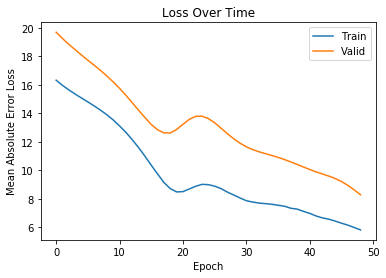

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [8]:
test_pred = TCN.predict(test)
print(test_pred.shape)
# print(test[0:20])
# print("-------------------------")
# print(test_pred[0:10])


(28, 50, 1)


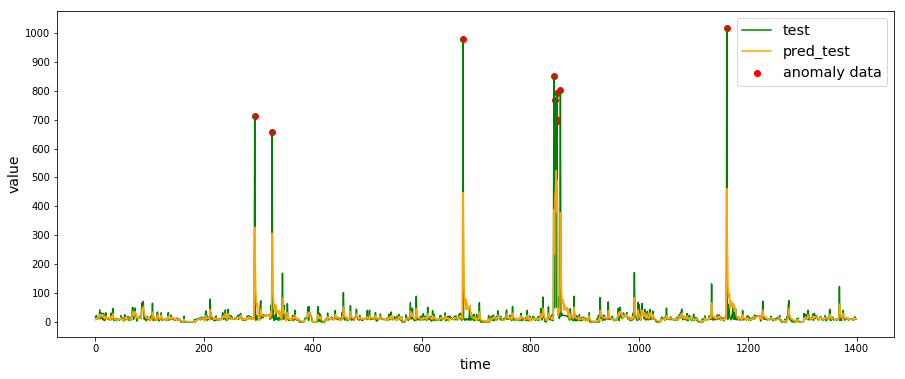

In [9]:
from matplotlib.pyplot import MultipleLocator
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
y_major_locator=MultipleLocator(100)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
#plt.ylim(0,1000)
plt.plot(test1[0:],color="green")
plt.plot(test_pred1[0:],color="orange",linestyle='-')
for i in range(len(test1)):
    if test_label[i] == 1:
        plt.scatter(i,test1[i],color="red")          
plt.legend(('test','pred_test','anomaly data'),loc='upper right',fontsize='x-large')


In [114]:
#点集检测
pred_label=[]
for i in range(len(test1)):
    pred_label.append(0)#正常

PAsum_rela_erro=np.zeros((len(pred_label)), dtype = float)
for i in range(len(pred_label)):
    PAsum_rela_erro[i]=np.abs(test1[i]-test_pred1[i])
PAscores=PAsum_rela_erro.copy()
PAscores.sort()
print(PAscores)


[1.34840012e-02 1.79347992e-02 2.14915276e-02 ... 4.62389954e+02
 5.31067169e+02 5.53390350e+02]


In [115]:
PAscores[100]

0.42009162898642494

In [118]:
PAcutoff=int(0.989*len(PAscores))
PAthreshold=165#PAscores[PAcutoff]
print(PAthreshold)

165


In [119]:
for i in range(len(test1)):
    if PAsum_rela_erro[i] > PAthreshold:
        pred_label[i]=2 #异常

In [120]:
normal_rela_erro=0.5
#集体集检测
timestep=5
n=int(len(pred_label)/timestep)
CAsum_rela_erro=np.zeros(n+1, dtype = float)
for i in range(0,len(test1),timestep):
    for j in range(timestep):
            if ((i+j)<len(pred_label)) and (pred_label[i+j]==0):
                rela_erro=np.abs(test1[i+j]-test_pred1[i+j])
                CAsum_rela_erro[int(i/timestep)]=rela_erro+CAsum_rela_erro[int(i/timestep)]
              #  print()
            else:
                CAsum_rela_erro[int(i/timestep)]=normal_rela_erro+CAsum_rela_erro[int(i/timestep)]
                
                
CAscores=CAsum_rela_erro.copy()
CAscores.sort()
print(CAscores)


[  0.           1.46567959   2.5          3.55167532   3.65864944
   4.07999206   4.77600527   5.15604734   5.31653213   5.32618999
   5.34170055   5.37686539   5.41836643   5.67611265   5.77528095
   6.0044446    6.09455371   6.27355766   6.35005379   6.42952776
   6.49439287   6.54181099   6.65258026   7.21671963   7.27829552
   7.30146122   7.7960062    7.9714036    8.01516008   8.12080252
   8.13988447   8.1689043    8.17096043   8.18362808   8.19663906
   8.56267357   8.71891719   9.1441164    9.17156124   9.18723774
   9.23538542   9.28323269   9.33128166   9.37520838   9.39442635
   9.52116942   9.61297417   9.65038109   9.90674591  10.01654911
  10.01811218  10.02245045  10.28138971  10.38730907  10.56291592
  10.56712818  10.72058582  10.93872356  11.13969517  11.30805254
  11.39040756  11.39674997  11.54478168  11.6200161   11.78993452
  11.89987659  11.94815779  12.09792757  12.13697052  12.32885134
  12.36465919  12.40906429  12.58589125  12.60752869  12.97053576
  13.08413

In [121]:
CAcutoff=int(0.99*len(CAscores))
CAthreshold=500#CAscores[CAcutoff]
print(CAscores[CAcutoff])

262.64027118688483


In [122]:
for i in range(n+1):
    if CAsum_rela_erro[i] > CAthreshold:
        for j in range(timestep):
            if i*timestep+j<len(pred_label) and pred_label[i*timestep+j]!=2:
                pred_label[i*timestep+j]=1
        

In [123]:
Perro_x=[]
Perro_y=[]
Cerro_x=[]
Cerro_y=[]
for i in range(len(test1)):
    if pred_label[i]==2:
        Perro_x.append(i)
        Perro_y.append(test1[i])
    elif pred_label[i]==1:
        Cerro_x.append(i)
        Cerro_y.append(test1[i])

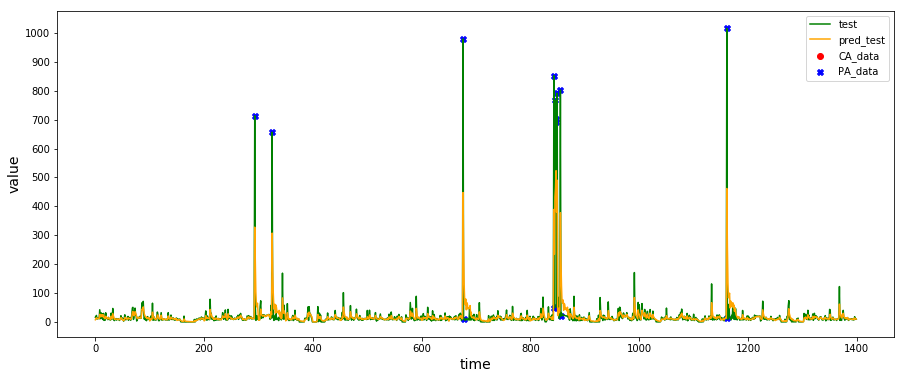

In [124]:
from matplotlib.pyplot import MultipleLocator
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
y_major_locator=MultipleLocator(100)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
#plt.ylim(0,1000)
plt.plot(test1[0:],color="green",label='test')
plt.plot(test_pred1[0:],color="orange",linestyle='-',label='pred_test')
plt.scatter(Cerro_x,Cerro_y,color="red",label='CA_data')
plt.scatter(Perro_x,Perro_y,color="blue",marker="X",label='PA_data')          
plt.legend()


In [125]:
Pred_label=[]
for i in range(len(pred_label)):
    if pred_label[i]==0:
        Pred_label.append(0)
    else:
        Pred_label.append(1)

In [126]:
print("CA:",pred_label.count(1))
print("PA:",pred_label.count(2))
ROC=roc_auc_score(test_label,Pred_label)
print("ROC_AUC score:{:2%}".format(ROC))  
precision, recall, _thresholds = precision_recall_curve(test_label, Pred_label)
PR_AUC = auc(recall, precision)
print("PR-AUC score:{:2%}".format(PR_AUC)) 

CA: 0
PA: 15
ROC_AUC score:99.820144%
PR-AUC score:83.333333%


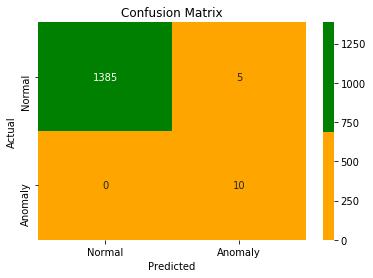

In [127]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(6, 4))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

viz = Visualization()
viz.draw_confusion_matrix(test_label,Pred_label)